temp_wh.dat + manually selected spike time -- filter -- threshold crossing -- pca

In [101]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/Users/xiao-zy19/Desktop/good_cs')
data = np.fromfile('temp_wh.dat', dtype=np.int16).reshape(-1, 128) #reshape((-1, 128))
print(data.shape)

(6166400, 128)


In [102]:
# design filters
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt

# Sample rate and desired cutoff frequencies
fs = 30000  # Sample rate
lowcut = 600  # High-pass filter cutoff frequency
highcut = 3000  # High corner frequency for the band-pass filter
lowcut_bp = 300  # Low corner frequency for the band-pass filter

# Butterworth High-Pass Filter
def butter_highpass(cutoff, fs, order=10):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Band-Pass Filter
def butter_bandpass(lowcut_bp, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut_bp / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def apply_filter(data, b, a):
    y = filtfilt(b, a, data)
    return y

# initialize the filters
b_high, a_high = butter_highpass(lowcut, fs, order=10)
b_band, a_band = butter_bandpass(lowcut_bp, highcut, fs, order=3)

In [103]:
# plt.figure(figsize=(10, 6))
# for channel in range(21, 26, 1):
#     data_filtered = data[:, channel]
#     time = int(72.5615 * 30000)
    
#     plt.plot(2000*(channel-23)+data_filtered[time-100:time+100], label='channel {}'.format(channel), alpha=0.7)
# plt.legend()
# plt.grid(linestyle='--', alpha=0.3)
# plt.show()

[2174505, 2176845, 3407550, 4024905, 4025010, 4025303, 4026132, 4027341]


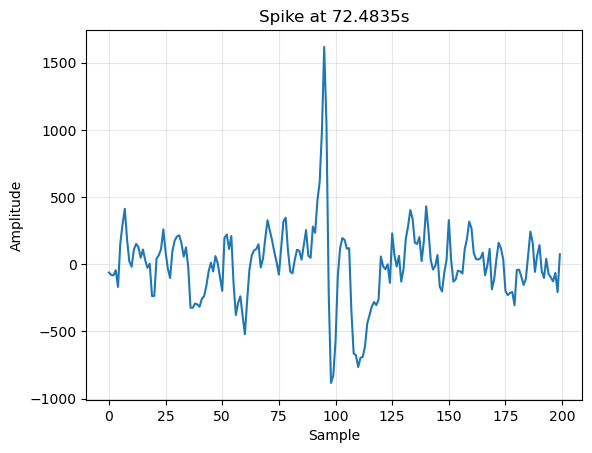

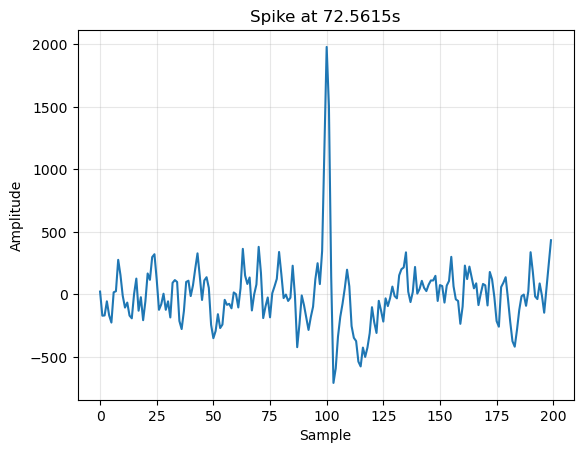

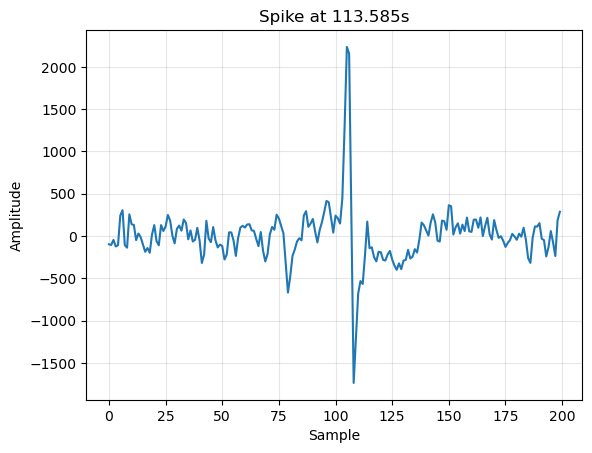

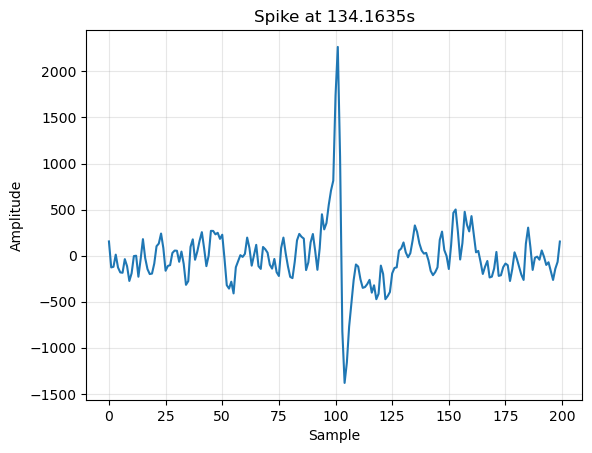

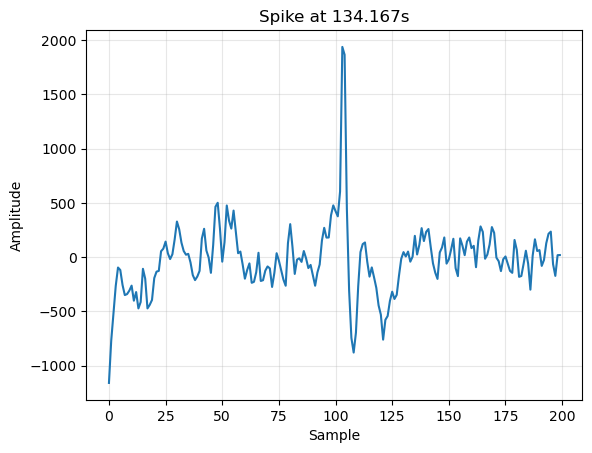

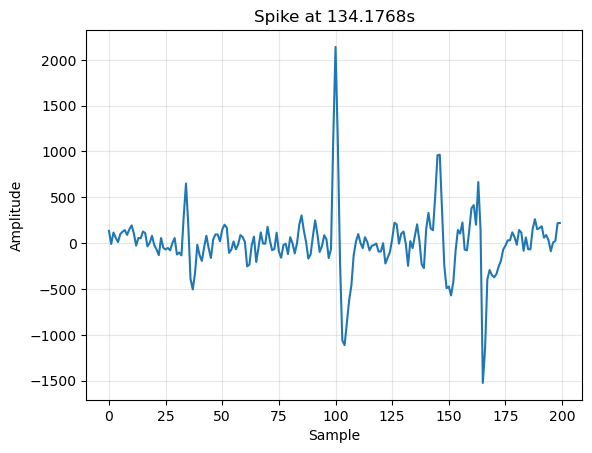

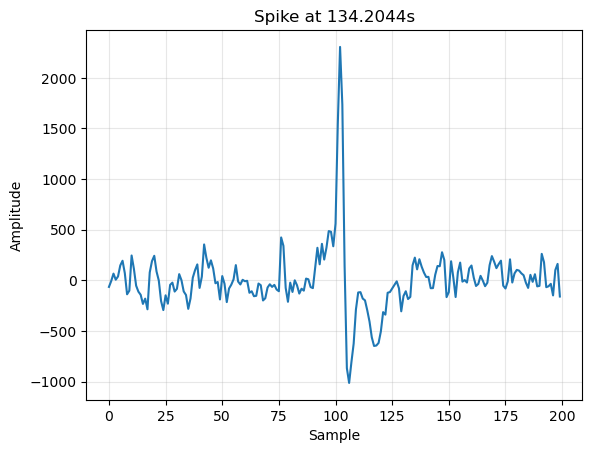

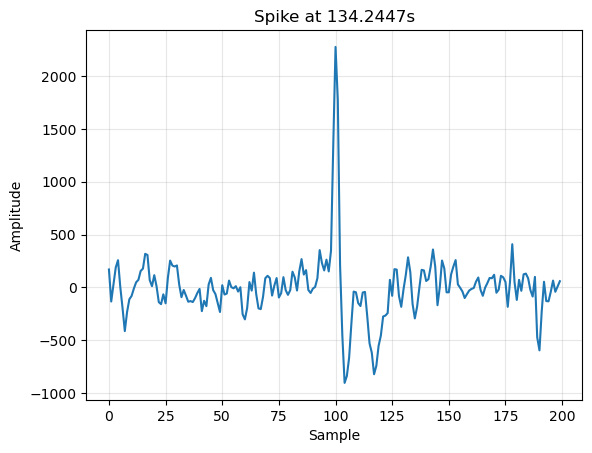

In [104]:
channel23 = data[:, 23]

complex_spike_time = [72.4835, 72.5615, 113.585, 134.1635, 134.167, 134.1768, 134.2044, 134.2447] #  93.076,
complex_spike_index = [int(x*30000) for x in complex_spike_time]
print(complex_spike_index)

for i in range(len(complex_spike_index)):
    plt.figure()
    plt.plot(channel23[complex_spike_index[i]-100:complex_spike_index[i]+100])
    plt.title(f'Spike at {complex_spike_time[i]}s')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.3)
    plt.show()

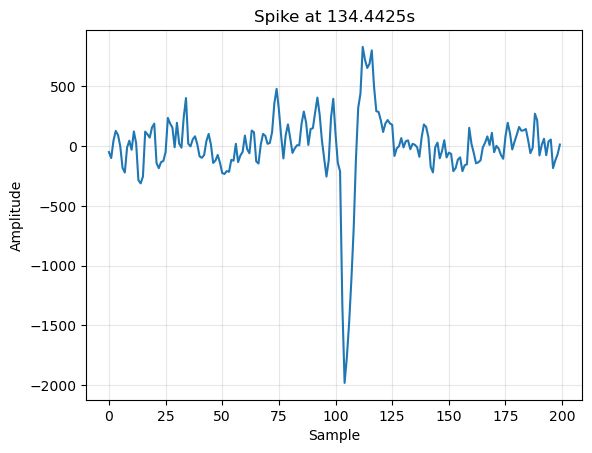

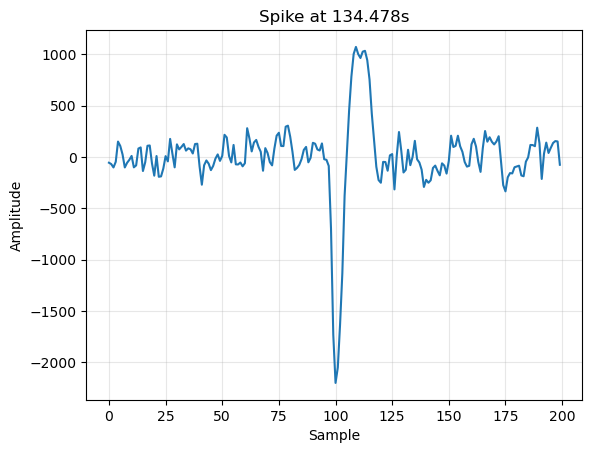

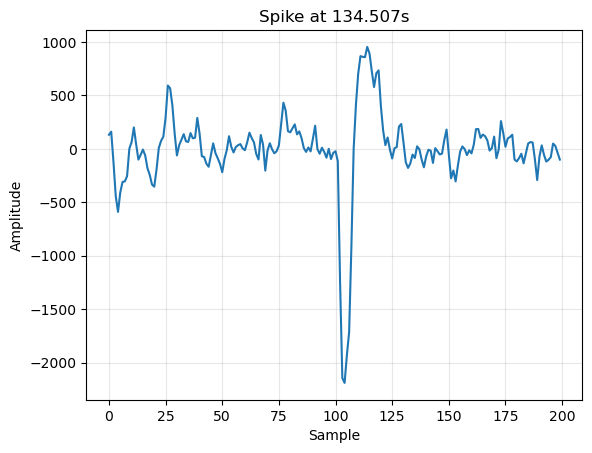

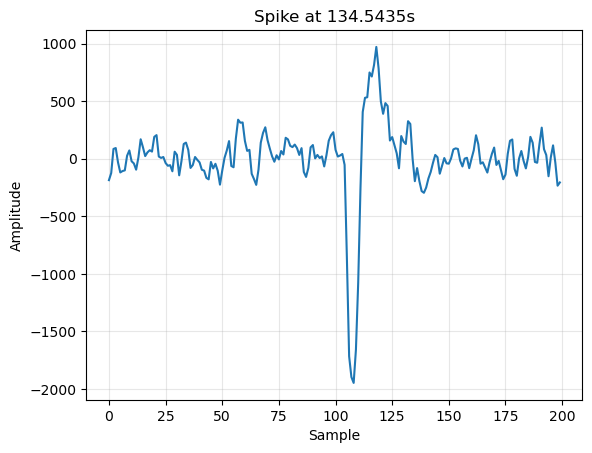

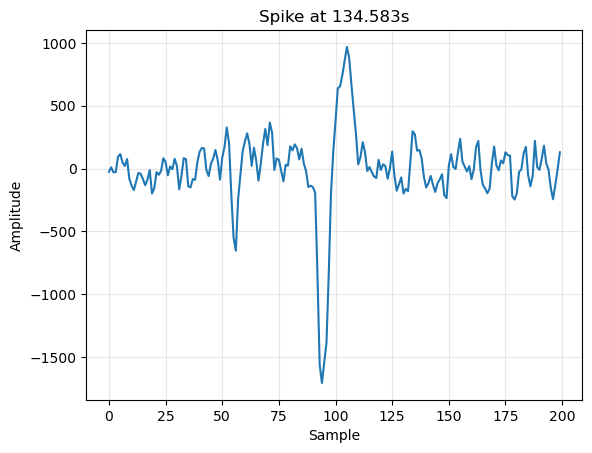

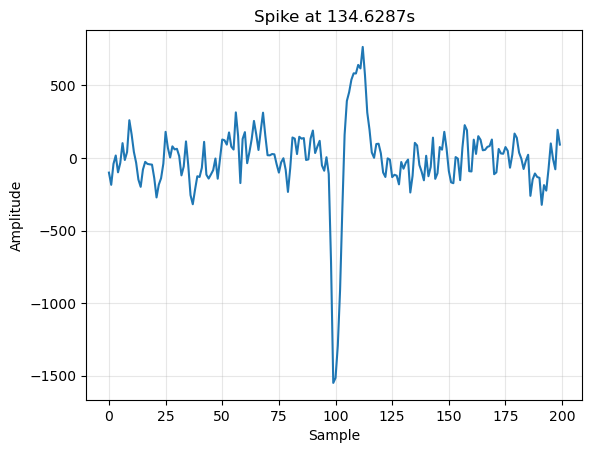

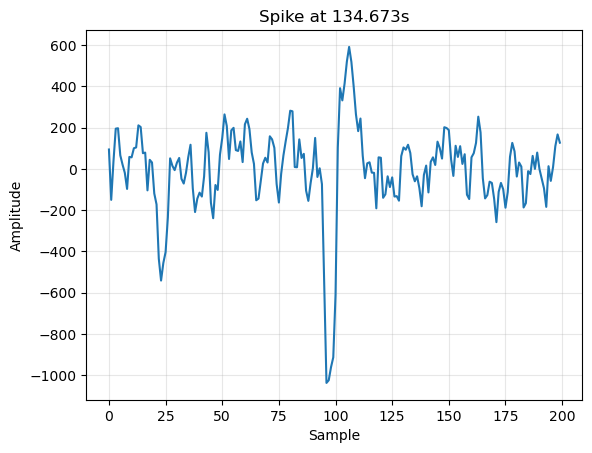

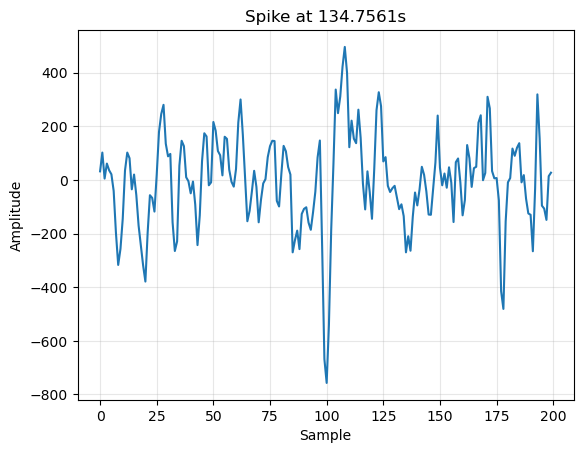

In [105]:
channel22 = data[:, 22]

simple_spike_time = [134.4425, 134.478, 134.507, 134.5435, 134.583, 134.6287, 134.673, 134.7561]
simple_spike_index = [int(x*30000) for x in simple_spike_time]

for i in range(len(simple_spike_index)):
    plt.figure()
    plt.plot(channel22[simple_spike_index[i]-100:simple_spike_index[i]+100])
    plt.title(f'Spike at {simple_spike_time[i]}s')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.3)
    plt.show()

(720300,)
(720000,)
(1440300,)


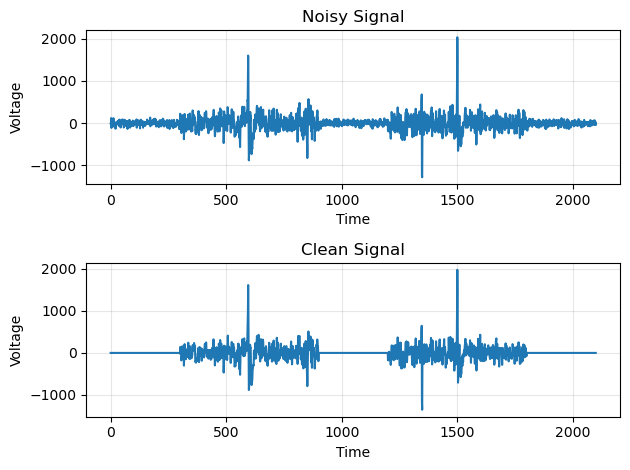

In [106]:
# randomly repeat complex spike index
complex_spike_index = complex_spike_index * 100
new_signal1 = np.zeros(300)
for i in range(len(complex_spike_index)):
    new_signal1 = np.concatenate((new_signal1, channel23[complex_spike_index[i]-300:complex_spike_index[i]+300], np.zeros(300)), axis=0)
# new_signal1 = new_signal1[200:]
print(new_signal1.shape)

# repeat simple spike index 6 times
simple_spike_index = simple_spike_index * 100
new_signal2 = np.zeros(300)
for i in range(len(simple_spike_index)):
    new_signal2 = np.concatenate((new_signal2, channel22[simple_spike_index[i]-300:simple_spike_index[i]+300], np.zeros(300)), axis=0)
new_signal2 = new_signal2[300:]
print(new_signal2.shape)

# concatenate the two signals
new_signal = np.concatenate((new_signal1, new_signal2), axis=0)
print(new_signal.shape)

# add random noise to the signal
noise = np.random.normal(0, 50, len(new_signal))
# noise = np.zeros(len(new_signal))
noisy_signal = new_signal + noise

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(noisy_signal[:2100])
plt.title('Noisy Signal')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(new_signal[:2100])
plt.title('Clean Signal')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

threshold: 80, crossing points: 36189


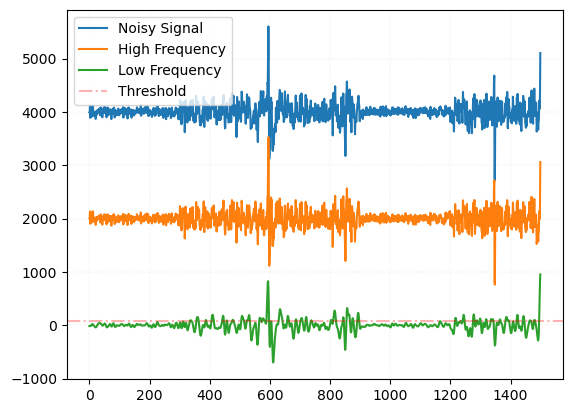

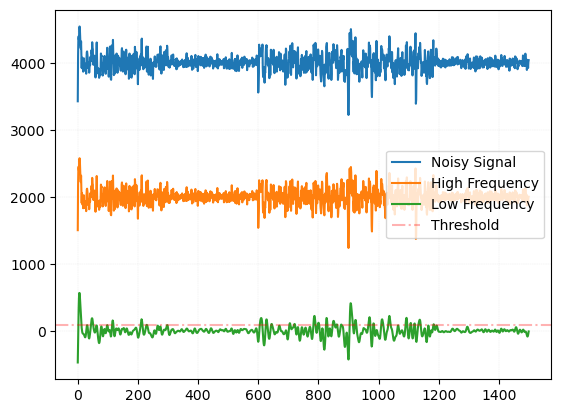

In [107]:
low_freq_data = apply_filter(noisy_signal, b_band, a_band)
high_freq_data = apply_filter(noisy_signal, b_high, a_high)

# thresholds
threshold = 80
crossing_points = np.where(np.diff((low_freq_data > threshold).astype(int)) == 1)[0]

# crossing_points = []
# for i in range(len(noisy_signal)//400 + 1):
#     crossing_points.append(400*i + 200)

print(f'threshold: {threshold}, crossing points: {crossing_points.shape[0]}')

plt.figure()
plt.plot(4000+noisy_signal[:1500], label='Noisy Signal')
plt.plot(2000+high_freq_data[:1500], label='High Frequency')
plt.plot(low_freq_data[:1500], label='Low Frequency')
plt.axhline(y=threshold, color='r', linestyle='-.', label='Threshold', alpha=0.3)
plt.grid(linestyle='--', alpha=0.3, linewidth=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(4000+noisy_signal[-1500:], label='Noisy Signal')
plt.plot(2000+high_freq_data[-1500:], label='High Frequency')
plt.plot(low_freq_data[-1500:], label='Low Frequency')
plt.axhline(y=threshold, color='r', linestyle='-.', label='Threshold', alpha=0.3)
plt.grid(linestyle='--', alpha=0.3, linewidth=0.3)
plt.legend()
plt.show()

In [108]:
low_pre_ms = 2
low_segment_ms = 10
high_pre_ms = 0.5
high_segment_ms = 2

low_freq_segments = []
high_freq_segments = []
labels = []

for point in crossing_points:
    if point - low_pre_ms * fs / 1000 < 0 or point + low_segment_ms * fs / 1000 > len(low_freq_data):
        continue
    start_low = int(point - low_pre_ms * fs / 1000)
    end_low = int(start_low + low_segment_ms * fs / 1000)
    
    start_high = int(point - high_pre_ms * fs / 1000)
    end_high = int(start_high + high_segment_ms * fs / 1000)
    low_freq_segments.append(low_freq_data[start_low:end_low])
    high_freq_segments.append(high_freq_data[start_high:end_high])
    
    if point < len(new_signal1) and point % 900 < 700 and point % 900 > 400:
        labels.append(0)
    elif point > len(new_signal1) and point % 900 < 700 and point % 900 > 400: 
        labels.append(1)
    else: 
        labels.append(2)
    
low_freq_segments = np.array(low_freq_segments)
high_freq_segments = np.array(high_freq_segments)

# align the high_freq_segments
for i, segment in enumerate(high_freq_segments):
    peak_index = np.argmax(segment)  # Find the peak index
    start_adjusted = max(0, peak_index - int(2 * fs / 1000))  # Adjust start
    end_adjusted = min(len(segment), peak_index + int(5 * fs / 1000))  # Adjust end index
    high_freq_segments[i] = segment[start_adjusted:end_adjusted]

In [109]:
from sklearn.decomposition import PCA

# Flatten the segments
low_freq_vectors = low_freq_segments.reshape(low_freq_segments.shape[0], -1)
high_freq_vectors = high_freq_segments.reshape(high_freq_segments.shape[0], -1)
print(f'low freq vectors shape: {low_freq_vectors.shape}, high freq vectors shape: {high_freq_vectors.shape}')

# Perform PCA
pca_low = PCA(n_components=2)
pca_high = PCA(n_components=2)

low_freq_pca = pca_low.fit_transform(low_freq_vectors)
high_freq_pca = pca_high.fit_transform(high_freq_vectors)
print(f'low freq pca shape: {low_freq_pca.shape}, high freq pca shape: {high_freq_pca.shape}')

low freq vectors shape: (36189, 300), high freq vectors shape: (36189, 60)
low freq pca shape: (36189, 2), high freq pca shape: (36189, 2)


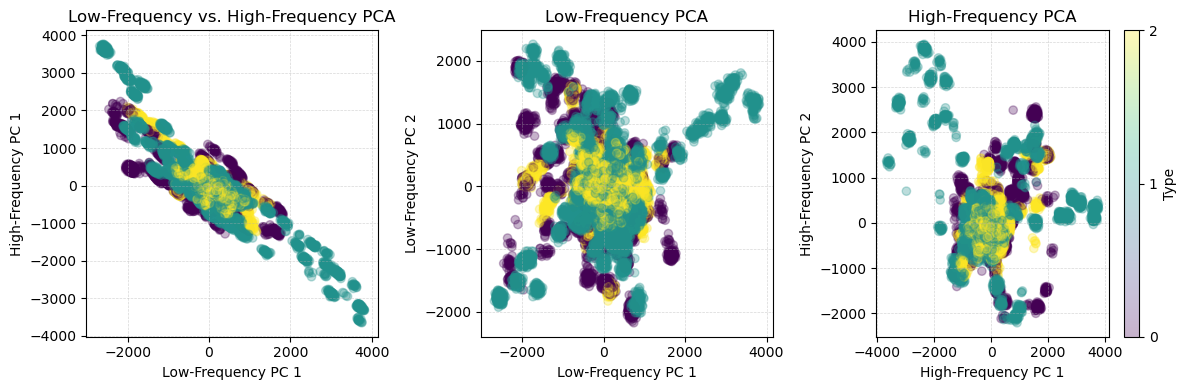

In [110]:
import matplotlib.pyplot as plt

# Plotting PCA results for low-frequency data
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(low_freq_pca[:, 0], high_freq_pca[:, 0], alpha=0.3, c=labels, cmap='viridis')
plt.title('Low-Frequency vs. High-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('High-Frequency PC 1')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.subplot(1, 3, 2)
plt.scatter(low_freq_pca[:, 0], low_freq_pca[:, 1], alpha=0.3, c=labels, cmap='viridis')
plt.title('Low-Frequency PCA')
plt.xlabel('Low-Frequency PC 1')
plt.ylabel('Low-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.subplot(1, 3, 3)
plt.scatter(high_freq_pca[:, 0], high_freq_pca[:, 1], alpha=0.3, c=labels, cmap='viridis')
plt.title('High-Frequency PCA')
plt.xlabel('High-Frequency PC 1')
plt.ylabel('High-Frequency PC 2')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.colorbar(label='Type', ticks=[0, 1, 2])
plt.tight_layout()
plt.show()